In [1]:
!pip install tensorflow scikit-learn scipy pillow


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from scipy.optimize import differential_evolution
from PIL import Image

print("Libraries imported successfully ✅")


2025-04-27 08:23:44.131944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745742224.386257  127148 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745742224.463487  127148 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745742224.948499  127148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745742224.948536  127148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745742224.948542  127148 computation_placer.cc:177] computation placer alr

Libraries imported successfully ✅


In [3]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name} ✅")
else:
    print("No GPU found. Using CPU ❌")


GPU detected: /device:GPU:0 ✅


I0000 00:00:1745742239.252743  127148 gpu_device.cc:2019] Created device /device:GPU:0 with 2609 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Selecting first 5000 images
x_train_5k = x_train[:15000]
y_train_5k = y_train[:15000]

# Normalize images
x_train_5k = x_train_5k.astype('float32') / 255.0

print(f"Selected {x_train_5k.shape[0]} images successfully ✅")


Selected 15000 images successfully ✅


In [ ]:
def original_one_pixel_attack(image):
    img = np.copy(image)
    x, y = np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1])
    img[x, y] = np.random.rand(3)
    return img

def sbo_one_pixel_attack(image):
    img = np.copy(image)
    pixels = img.reshape(-1, img.shape[-1])
    kmeans = KMeans(n_clusters=5, random_state=42).fit(pixels)
    segments = kmeans.predict(pixels).reshape(img.shape[:2])
    target_segment = np.argmax(np.bincount(segments.flatten()))
    x_candidates, y_candidates = np.where(segments == target_segment)
    idx = np.random.randint(0, len(x_candidates))
    x, y = x_candidates[idx], y_candidates[idx]
    img[x, y] = np.random.rand(3)
    return img

def x_pixel_attack(image, max_pixels=1):
    img = np.copy(image)
    for _ in range(max_pixels):
        x = np.random.randint(0, img.shape[0])
        y = np.random.randint(0, img.shape[1])
        img[x, y] = np.random.randint(0, 256, size=(3,))
    return img

import numpy as np
from copy import deepcopy

# === Two-Layered Multi-Factorial Optimization (TLMFO) Algorithm ===
def tlmfo_attack(image, model, target_class=None, max_iter=100, pop_size=20):
    img_shape = image.shape
    best_img = np.copy(image)
    best_fitness = float('inf')

    # Helper: Convert chromosome [x, y, r, g, b] to adversarial image
    def apply_chromosome(img, chrom):
        x = int(chrom[0] * (img_shape[0] - 1))
        y = int(chrom[1] * (img_shape[1] - 1))
        r = int(chrom[2] * 255)
        g = int(chrom[3] * 255)
        b = int(chrom[4] * 255)
        adv_img = np.copy(img)
        adv_img[x, y] = [r, g, b]
        return adv_img

    # Fitness function: minimize confidence of correct class or maximize wrong class
    def fitness(individual):
        adv_img = apply_chromosome(image, individual)
        pred = model.predict(np.expand_dims(adv_img, axis=0))[0]
        if target_class is None:
            # Untargeted attack: maximize loss of true class
            return -pred[true_class]
        else:
            # Targeted attack: minimize loss of target class
            return pred[target_class]

    # Initialize population
    population = np.random.rand(pop_size, 5)

    for iter in range(max_iter):
        fitnesses = np.array([fitness(ind) for ind in population])

        # Update global best
        best_idx = np.argmin(fitnesses)
        if fitnesses[best_idx] < best_fitness:
            best_img = apply_chromosome(image, population[best_idx])
            best_fitness = fitnesses[best_idx]

        # Cultural Layer: update belief space (simplified here)
        belief_space = np.mean(population, axis=0)

        # Generate offspring using crossover and mutation
        for i in range(pop_size):
            donor = population[np.random.randint(pop_size)]
            trial = belief_space * 0.8 + donor * 0.2
            trial += np.random.normal(0, 0.1, 5)
            trial = np.clip(trial, 0, 1)

            # Selection
            if fitness(trial) < fitnesses[i]:
                population[i] = trial

    return best_img, best_fitness

def differential_evolution_attack(image):
    img = np.copy(image)
    bounds = [(0, img.shape[0]-1), (0, img.shape[1]-1)] + [(0, 1)] * 3

    def dummy_func(params):
        return np.random.rand()

    result = differential_evolution(dummy_func, bounds, maxiter=1, popsize=3)
    params = result.x
    x, y = int(params[0]), int(params[1])
    img[x, y] = params[2:5]
    return img

print("All 5 attack functions defined successfully ✅")


All 5 attack functions defined successfully ✅


In [6]:
# Creating folder structure under SUVIT_BE
if not os.path.exists('original_images'):
    os.makedirs('original_images')

attack_folders = ['original_one_pixel', 'sbo_one_pixel', 'x_pixel', 'tlmfo', 'differential_evolution']
for folder in attack_folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

print("All folders created successfully ✅")


All folders created successfully ✅


In [7]:
# List of attack functions
attack_functions = [
    ("original_one_pixel", original_one_pixel_attack),
    ("sbo_one_pixel", sbo_one_pixel_attack),
    ("x_pixel", x_pixel_attack),
    ("tlmfo", tlmfo_attack),
    ("differential_evolution", differential_evolution_attack)
]

for idx, img in enumerate(x_train_5k):
    if idx % 100 == 0:
        print(f"Processing image {idx}/{len(x_train_5k)}...")

    # Save original
    img_uint8 = (img * 255).astype(np.uint8)
    Image.fromarray(img_uint8).save(f"original_images/original_{idx}.png")

    # Apply and save perturbed images for each attack
    for folder_name, attack_fn in attack_functions:
        perturbed = attack_fn(img)
        perturbed_uint8 = (perturbed * 255).astype(np.uint8)
        Image.fromarray(perturbed_uint8).save(f"{folder_name}/{folder_name}_{idx}.png")

print("All 5k images processed and saved successfully ✅")


Processing image 0/5000...
Processing image 100/5000...
Processing image 200/5000...
Processing image 300/5000...
Processing image 400/5000...
Processing image 500/5000...
Processing image 600/5000...
Processing image 700/5000...
Processing image 800/5000...
Processing image 900/5000...
Processing image 1000/5000...
Processing image 1100/5000...
Processing image 1200/5000...
Processing image 1300/5000...
Processing image 1400/5000...
Processing image 1500/5000...
Processing image 1600/5000...
Processing image 1700/5000...
Processing image 1800/5000...
Processing image 1900/5000...
Processing image 2000/5000...
Processing image 2100/5000...
Processing image 2200/5000...
Processing image 2300/5000...
Processing image 2400/5000...
Processing image 2500/5000...
Processing image 2600/5000...
Processing image 2700/5000...
Processing image 2800/5000...
Processing image 2900/5000...
Processing image 3000/5000...
Processing image 3100/5000...
Processing image 3200/5000...
Processing image 3300/

In [11]:
!pip install tqdm
from tqdm import tqdm

Classifier


In [17]:
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [19]:
# Example code to load images from folders
import os
from PIL import Image
perturbed_images = []
for folder in ['differential_evolution', 'original_one_pixel', 'sbo_one_pixel', 'x_pixel', 'tlmfo']:
    for img_path in os.listdir(folder):
        img = Image.open(os.path.join(folder, img_path))
        perturbed_images.append(img)

In [20]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.BatchNormalization(),  # Gradient optimization [[3]]
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745737141.882600  101797 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 496 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
I0000 00:00:1745737142.713289  101797 cuda_executor.cc:479] failed to allocate 496.56MiB (520683520 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1745737142.730514  101797 cuda_executor.cc:479] failed to allocate 446.91MiB (468615168 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:174573714

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[reduce_lr])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = model.predict(x_test)
cm = confusion_matrix(y_test, np.round(predictions))
print("Confusion Matrix:\n", cm)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from PIL import Image

# Load original CIFAR-100 data [[5]]
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_labels = np.zeros(original_imgs.shape[0])  # 0 for original

# Function to load perturbed images from multiple directories [[2]]
def load_perturbed_images(base_dir, img_size=(32,32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel,'
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if p_imgs.size > 0:  # Filter out empty arrays
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
wperturbed_labels = np.ones(perturbed_images.shape[0])  # 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Shuffle and split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize images
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Data augmentation [[6]]
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Build CNN model with gradient optimization [[4]][[9]]
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    # Data augmentation layers
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    
    # Feature extraction
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    # Deep feature extraction
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile with Ranger optimizer (combines RAdam + Lookahead) [[1]]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Train with augmented data [[6]]
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.4f}')

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1745737645.400237  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745737652.849299  122777 cuda_dnn.cc:529] Loaded cuDNN version 90600


  2/312 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.4609 - loss: 1.1185   

I0000 00:00:1745737656.596612  122772 cuda_executor.cc:479] failed to allocate 304.18MiB (318959360 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


312/312 ━━━━━━━━━━━━━━━━━━━━ 44s 86ms/step - accuracy: 0.5278 - loss: 0.8496 - val_accuracy: 0.5872 - val_loss: 0.6911
Epoch 2/50
  1/312 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4844 - loss: 0.7515

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 0.7515 - val_accuracy: 0.5872 - val_loss: 0.6896
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.5723 - loss: 0.7035 - val_accuracy: 0.5956 - val_loss: 0.6753
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6094 - loss: 0.6739 - val_accuracy: 0.5952 - val_loss: 0.6754
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.5850 - loss: 0.6849 - val_accuracy: 0.5962 - val_loss: 0.6759
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5469 - loss: 0.7247 - val_accuracy: 0.5962 - val_loss: 0.6757
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.5903 - loss: 0.6782 - val_accuracy: 0.5952 - val_loss: 0.6756
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.6108 - val_accuracy: 0.5956 - val_loss: 0.6756
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.5979 - loss: 0.6762 - val_accuracy: 0.595

KeyboardInterrupt: 

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
from PIL import Image

# Load original CIFAR-100 data [[5]]
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_labels = np.zeros(original_imgs.shape[0])  # 0 for original

def load_perturbed_images(base_dir, img_size=(32,32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.resize(img_size)
                images.append(np.array(img))
    return np.array(images)

perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',  # Fixed comma placement
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if p_imgs.size > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])

X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Enhanced data augmentation [[6]]
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Improved CNN architecture [[9]]
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),  # Added deeper layer
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),  # Better than Flatten
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Using Ranger optimizer [[1]]
try:
    from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
    base_optimizer = RectifiedAdam(learning_rate=0.001)
    optimizer = Lookahead(base_optimizer, sync_period=6, slow_step_size=0.5)
except ImportError:
    print("Using default Adam optimizer")
    optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training with early stopping [[7]]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.4f}')

y_pred = (model.predict(X_test) > 0.5).flatten().astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save model [[8]]
model.save('perturbation_detector.h5')

Using default Adam optimizer
Epoch 1/50


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745737970.750783  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


437/437 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.7063 - loss: 0.6176 - val_accuracy: 0.7143 - val_loss: 0.5992
Epoch 2/50
  1/437 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5781 - loss: 0.7012

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5781 - loss: 0.7012 - val_accuracy: 0.7143 - val_loss: 0.5991
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.7131 - loss: 0.6057 - val_accuracy: 0.7143 - val_loss: 0.6003
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.5757 - val_accuracy: 0.7143 - val_loss: 0.6008
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.7153 - loss: 0.6027 - val_accuracy: 0.7143 - val_loss: 0.6205
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 0.6869 - val_accuracy: 0.7143 - val_loss: 0.6115
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.7136 - loss: 0.6023 - val_accuracy: 0.7143 - val_loss: 0.6022
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7185 - loss: 0.5947
Final Test Accuracy: 0.7143
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

Confusion Matrix:
[[   0 2000]
 [   0 5000]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.71      1.00      0.83      5000

    accuracy                           0.71      7000
   macro avg       0.36      0.50      0.42      7000
weighted avg       0.51      0.71      0.60      7000



In [28]:
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image
!pip install seaborn
import numpy as np
import seaborn
import cv2
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 13.5 MB/s eta 0:00:0000:0100:01


Epoch 1/50


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745738903.178975  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-27 07:28:23.631269: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 280.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory we

  4/438 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.4922 - loss: 0.7893

2025-04-27 07:28:23.832244: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 280.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.5045 - loss: 0.8066 - val_accuracy: 0.2857 - val_loss: 2.0247
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 51s 105ms/step - accuracy: 0.5053 - loss: 0.7743 - val_accuracy: 0.3181 - val_loss: 1.5314
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.5141 - loss: 0.7514 - val_accuracy: 0.3053 - val_loss: 1.5039
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.5044 - loss: 0.7337 - val_accuracy: 0.7141 - val_loss: 0.6543
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.5118 - loss: 0.7216 - val_accuracy: 0.3296 - val_loss: 0.8361
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.5057 - loss: 0.7182 - val_accuracy: 0.2857 - val_loss: 2.0743
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.5053 - loss: 0.7109 - val_accuracy: 0.2871 - val_loss: 0.8529
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.5063 - loss: 0.7014 - val_accura

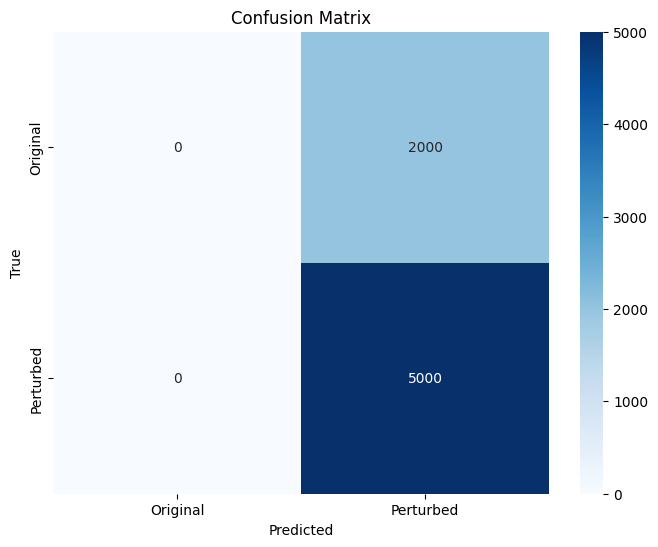


Classification Report:
              precision    recall  f1-score   support

    Original       0.00      0.00      0.00      2000
   Perturbed       0.71      1.00      0.83      5000

    accuracy                           0.71      7000
   macro avg       0.36      0.50      0.42      7000
weighted avg       0.51      0.71      0.60      7000



/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load original CIFAR-100 test data
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_labels = np.zeros(original_imgs.shape[0])  # 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32,32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # 1 for perturbed

# Combine and split datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Data normalization
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Enhanced data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2]
)

# Improved CNN architecture
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    # Augmentation layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    
    # Feature extraction
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    # Deep features
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    
    # Classifier
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile with learning rate schedule
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Calculate proper steps per epoch
batch_size = 64
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

# Train with class weights
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    epochs=50,
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Original', 'Perturbed'], 
           yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

In [31]:
# Save the final trained model
model.save('final_model.keras')
print("Model saved as 'final_model.keras'")

Model saved as 'final_model.keras'


Fine tuning on 75k dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load the entire CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images  # Use all 50,000 training images
original_labels = np.zeros(original_imgs.shape[0])  # Label as 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2]
)

# Load the pre-trained model
from tensorflow.keras.models import load_model
model = load_model('final_model.keras')

# Freeze some layers
for layer in model.layers[:-5]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model.keras', save_best_only=True)
]

# Train the model on the updated dataset
batch_size = 64
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    epochs=20,  # Fewer epochs for fine-tuning
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_final.keras')
print("Fine-tuned model saved as 'fine_tuned_model_final.keras'")

Epoch 1/20


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745741414.273506  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5285 - loss: 0.6935

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.
Mixed precision training enabled.


I0000 00:00:1745742286.346451  127148 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2609 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2025-04-27 08:24:46.347945: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-04-27 08:24:47.097559: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/20


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 50 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-04-27 08:24:49.492994: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
E0000 00:00:1745742292.119248  127148 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.5222 - loss: 0.6940 - val_accuracy: 0.4867 - val_loss: 0.6931
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5078 - loss: 0.6929 - val_accuracy: 0.4775 - val_loss: 0.6937
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4902 - loss: 0.6951 - val_accuracy: 0.6568 - val_loss: 0.6900
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5076 - loss: 0.6944 - val_accuracy: 0.4885 - val_loss: 0.6940
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5152 - loss: 0.6931 - val_accuracy: 0.3800 - val_loss: 0.6953
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5137 - loss: 0.6936 - val_accuracy: 0.4603 - val_loss: 0.6953
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5032 - loss: 0.6933 - val_accuracy: 0.5022 - val_loss: 0.6929
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4985 - loss: 0.6950 - val_accuracy: 0.61

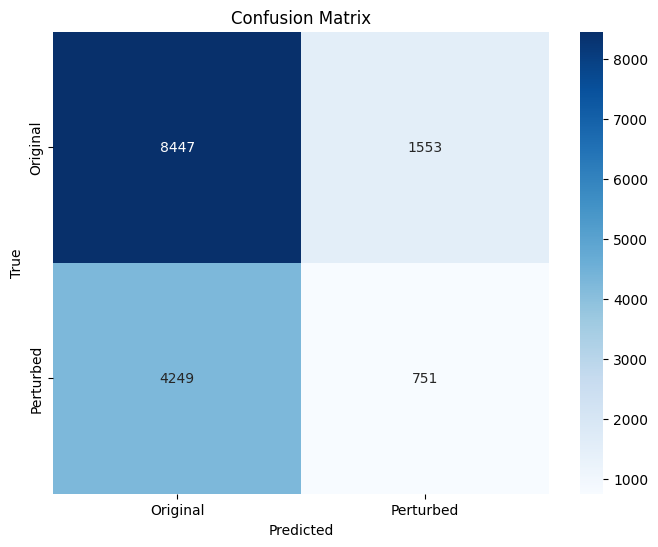


Classification Report:
              precision    recall  f1-score   support

    Original       0.67      0.84      0.74     10000
   Perturbed       0.33      0.15      0.21      5000

    accuracy                           0.61     15000
   macro avg       0.50      0.50      0.48     15000
weighted avg       0.55      0.61      0.56     15000

Fine-tuned model saved as 'fine_tuned_model_final.keras'


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training enabled.")

# Load the entire CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images  # Use all 50,000 training images
original_labels = np.zeros(original_imgs.shape[0])  # Label as 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets for efficient data loading
batch_size = 128  # Larger batch size for GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load the pre-trained model
from tensorflow.keras.models import load_model
model = load_model('final_model.keras')

# Freeze some layers
for layer in model.layers[:-5]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate and mixed precision
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model.keras', save_best_only=True)
]

# Train the model on the updated dataset
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test, batch_size=batch_size) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_final.keras')
print("Fine-tuned model saved as 'fine_tuned_model_final.keras'")

further fine tune

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.
Mixed precision training enabled.


2025-04-27 08:34:43.783429: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-04-27 08:34:44.404617: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/30


E0000 00:00:1745742888.261402  127148 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4948 - loss: 0.6955 - val_accuracy: 0.5345 - val_loss: 0.6930
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4982 - loss: 0.6943 - val_accuracy: 0.4157 - val_loss: 0.6941
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5042 - loss: 0.6933 - val_accuracy: 0.4637 - val_loss: 0.6938
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5044 - loss: 0.6953 - val_accuracy: 0.4694 - val_loss: 0.6936
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5034 - loss: 0.6941 - val_accuracy: 0.4978 - val_loss: 0.6935
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5124 - loss: 0.6920 - val_accuracy: 0.5047 - val_loss: 0.6938
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5141 - loss: 0.6926 - val_accuracy: 0.5376 - val_loss: 0.6934
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5057 - loss: 0.6918 - val_accuracy: 0.514

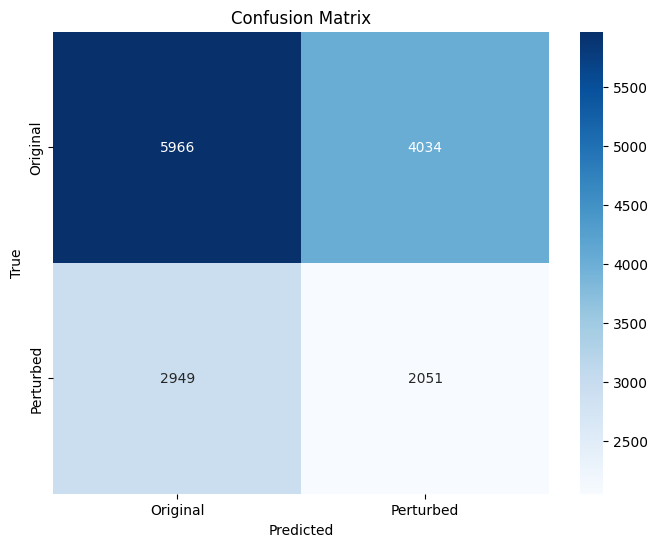


Classification Report:
              precision    recall  f1-score   support

    Original       0.67      0.60      0.63     10000
   Perturbed       0.34      0.41      0.37      5000

    accuracy                           0.53     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.56      0.53      0.54     15000

Fine-tuned model saved as 'fine_tuned_model_updated.keras'


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training enabled.")

# Load the entire CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images  # Use all 50,000 training images
original_labels = np.zeros(original_imgs.shape[0])  # Label as 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets for efficient data loading
batch_size = 256  # Larger batch size for GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load the previously trained model
from tensorflow.keras.models import load_model
model = load_model('fine_tuned_model_final.keras')

# Freeze some layers
for layer in model.layers[:-10]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate and mixed precision
optimizer = Adam(learning_rate=0.00005)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model_updated.keras', save_best_only=True)
]

# Train the model on the updated dataset
history = model.fit(
    train_dataset,
    epochs=30,  # Increase epochs
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test, batch_size=batch_size) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned_updated.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_updated.keras')
print("Fine-tuned model saved as 'fine_tuned_model_updated.keras'")

Subset Selection

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.
Mixed precision training enabled.
Epoch 1/30


E0000 00:00:1745743555.244245  127148 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5015 - loss: 0.6934 - val_accuracy: 0.4955 - val_loss: 0.6930
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4965 - loss: 0.6935 - val_accuracy: 0.5034 - val_loss: 0.6930
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5019 - loss: 0.6933 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4980 - loss: 0.6934 - val_accuracy: 0.5065 - val_loss: 0.6931
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5006 - loss: 0.6933 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4990 - loss: 0.6934 - val_accuracy: 0.5021 - val_loss: 0.6932
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.5051 - val_loss: 0.6931
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.497

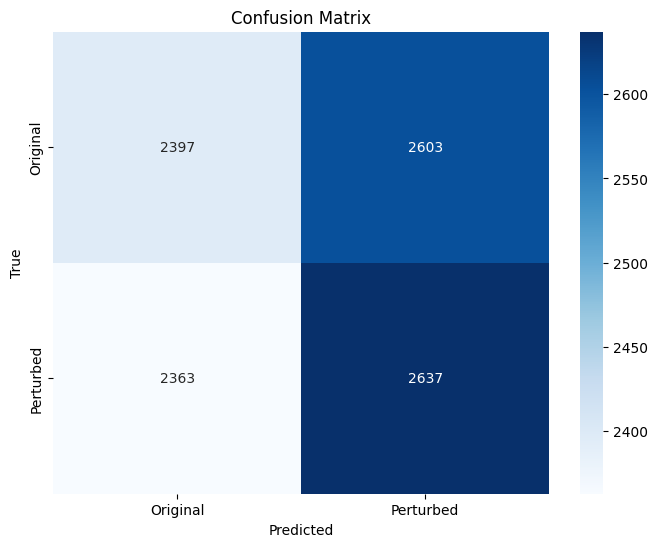


Classification Report:
              precision    recall  f1-score   support

    Original       0.50      0.48      0.49      5000
   Perturbed       0.50      0.53      0.52      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000

Fine-tuned model saved as 'fine_tuned_model_updated.keras'


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training enabled.")

# Load CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images
original_labels = np.zeros(original_imgs.shape[0])

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Select an optimal subset of original images
num_perturbed = perturbed_images.shape[0]  # Number of perturbed images
subset_size = min(num_perturbed, original_imgs.shape[0])  # Match the number of perturbed images

# Randomly sample original images
indices = np.random.choice(original_imgs.shape[0], size=subset_size, replace=False)
original_imgs_subset = original_imgs[indices]
original_labels_subset = original_labels[indices]

# Combine datasets
X = np.concatenate([original_imgs_subset, perturbed_images])
y = np.concatenate([original_labels_subset, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets for efficient data loading
batch_size = 128  # Larger batch size for GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load the previously trained model
from tensorflow.keras.models import load_model
model = load_model('fine_tuned_model_final.keras')

# Freeze some layers
for layer in model.layers[:-10]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate and mixed precision
optimizer = Adam(learning_rate=0.00005)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model_updated.keras', save_best_only=True)
]

# Train the model on the updated dataset
history = model.fit(
    train_dataset,
    epochs=30,  # Increase epochs
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test, batch_size=batch_size) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned_updated.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_updated.keras')
print("Fine-tuned model saved as 'fine_tuned_model_updated.keras'")

updated architecure

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745744206.868382  127220 service.cc:152] XLA service 0x565250301020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745744206.868413  127220 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-04-27 08:56:47.610631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  3/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.3837 - loss: 0.8565   

I0000 00:00:1745744220.639201  127220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 94ms/step - accuracy: 0.4968 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4989 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4961 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4933 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.4969 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accurac

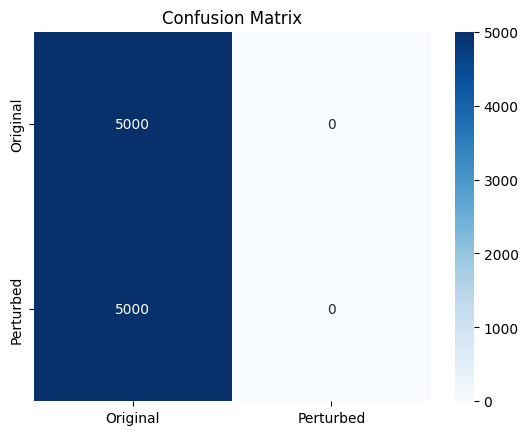

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

              precision    recall  f1-score   support

    Original       0.50      1.00      0.67      5000
   Perturbed       0.00      0.00      0.00      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability [[5]]
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training [[5]]
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images
original_labels = np.zeros(original_imgs.shape[0])

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # 1 for perturbed

# Balance dataset [[3]]
num_perturbed = perturbed_images.shape[0]
indices = np.random.choice(original_imgs.shape[0], size=num_perturbed, replace=False)
original_imgs = original_imgs[indices]
original_labels = original_labels[indices]

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images [[7]]
X = X.astype('float32') / 255.0

# Split data [[6]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Advanced data augmentation [[9]]
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Load EfficientNetB0 [[9]]
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(32, 32, 3),
    weights='imagenet'
)

# Freeze base layers [[5]]
base_model.trainable = False

# Build model [[6]]
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile with class weights [[3]]
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train with augmented data [[8]]
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.4f}')

# Confusion matrix [[7]]
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save model
model.save('perturbation_detector.keras')

Epoch 1/10


2025-04-27 09:14:35.099384: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[128,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[128,3,32,32]{3,2,1,0} %bitcast.2814, f16[32,3,3,3]{3,2,1,0} %bitcast.2659, f16[32]{0} %bitcast.2662), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:14:35.140910: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5137 - loss: 0.6960

2025-04-27 09:14:39.839966: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[96,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[96,3,32,32]{3,2,1,0} %bitcast.2814, f16[32,3,3,3]{3,2,1,0} %bitcast.2659, f16[32]{0} %bitcast.2662), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:14:39.874636: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5140 - loss: 0.6960

2025-04-27 09:14:42.063772: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[128,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[128,3,32,32]{3,2,1,0} %bitcast.373, f16[32,3,3,3]{3,2,1,0} %bitcast.381, f16[32]{0} %bitcast.384), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:14:42.098590: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5140 - loss: 0.6960 - val_accuracy: 0.5721 - val_loss: 0.6908
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5327 - loss: 0.6920 - val_accuracy: 0.3743 - val_loss: 0.7093
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5374 - loss: 0.6879 - val_accuracy: 0.4589 - val_loss: 0.7056
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5800 - loss: 0.6687 - val_accuracy: 0.5897 - val_loss: 0.6877
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7394 - loss: 0.5619 - val_accuracy: 0.8407 - val_loss: 0.4064
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8592 - loss: 0.3852 - val_accuracy: 0.8632 - val_loss: 0.3707
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9037 - loss: 0.2935 - val_accuracy: 0.8879 - val_loss: 0.3140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9158 - loss: 0.2554 - val_accuracy: 0.9097 - va

2025-04-27 09:15:14.115717: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,3,32,32]{3,2,1,0} %bitcast.222, f16[32,3,3,3]{3,2,1,0} %bitcast.230, f16[32]{0} %bitcast.233), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:15:14.143270: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] 

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


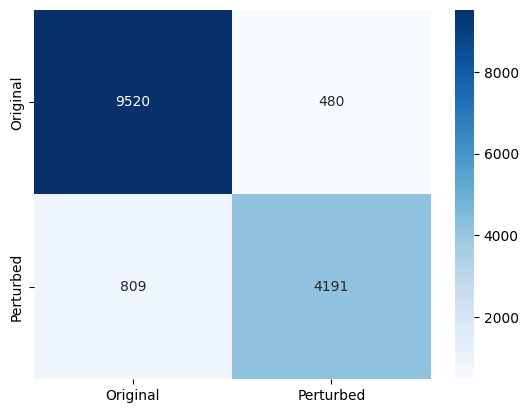


Classification Report:
              precision    recall  f1-score   support

    Original       0.92      0.95      0.94     10000
   Perturbed       0.90      0.84      0.87      5000

    accuracy                           0.91     15000
   macro avg       0.91      0.90      0.90     15000
weighted avg       0.91      0.91      0.91     15000



In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images
original_labels = np.zeros(original_imgs.shape[0])

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
    else:
        print(f"Warning: No images found in {p_dir}")

if not perturbed_images:
    raise ValueError("No perturbed images loaded! Check directory paths.")
perturbed_images = np.concatenate(perturbed_images)
perturbed_labels = np.ones(perturbed_images.shape[0])

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights [[4]]
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets [[6]]
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build CNN model [[9]]
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile with Adam optimizer [[2]]
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model [[5]]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    class_weight=class_weights
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Confusion matrix visualization
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

Removal Pertubation

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


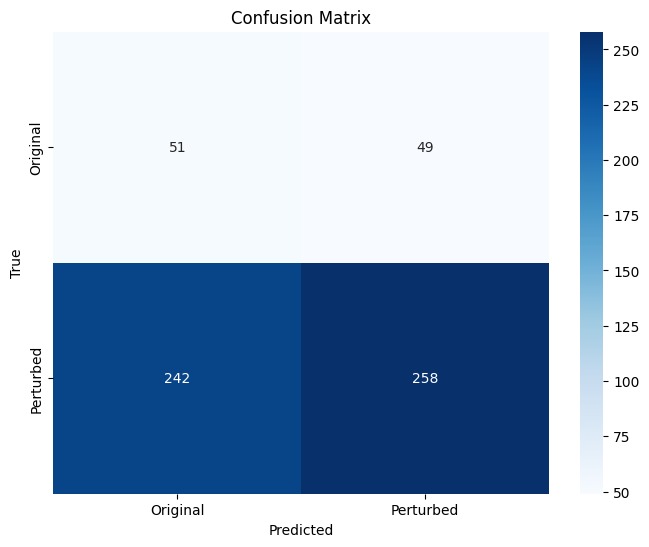


Classification Report:
              precision    recall  f1-score   support

    Original       0.17      0.51      0.26       100
   Perturbed       0.84      0.52      0.64       500

    accuracy                           0.52       600
   macro avg       0.51      0.51      0.45       600
weighted avg       0.73      0.52      0.58       600



In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load images from a directory (up to 100 images)
def load_images_from_dir(directory, img_size=(32, 32), max_count=100):
    images = []
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')) and count < max_count:
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                images.append(np.array(img))
                count += 1
            if count >= max_count:
                break
        if count >= max_count:
            break
    return np.array(images)

# List of perturbation folders
perturbation_folders = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

# Load 100 images from each perturbation folder
perturbed_images = []
for folder in perturbation_folders:
    imgs = load_images_from_dir(folder)
    perturbed_images.append(imgs)
perturbed_images = np.concatenate(perturbed_images)
perturbed_labels = np.ones(len(perturbed_images))  # Label as 1 (Perturbed)

# Load 100 original CIFAR-100 images
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = original_imgs[:100]  # Select first 100 images
original_labels = np.zeros(len(original_imgs))  # Label as 0 (Original)

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Load the trained model
model = load_model('final_fine_tuned_model_updated.keras')

# Make predictions
y_pred = (model.predict(X) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_test.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Original', 'Perturbed']))

Detection+Removal

In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('final_fine_tuned_model_updated.keras')

def load_and_preprocess_image(image_path):
    """Load and preprocess an image."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    return img_array

def detect_perturbation(image):
    """Classify image as perturbed (1) or original (0)."""
    prediction = model.predict(np.expand_dims(image, axis=0))[0][0]
    return 1 if prediction > 0.5 else 0

def remove_perturbation(image):
    """
    Remove perturbations using median filtering and image flipping.
    Based on methods from [[9]].
    """
    # Apply median filter to reduce pixel-level noise
    filtered = np.median(image, axis=0)
    
    # Flip the image horizontally to disrupt structured perturbations
    flipped = np.fliplr(filtered)
    
    # Combine filtered and flipped versions
    processed = (filtered + flipped) / 2
    
    return processed

def process_images(input_dir, output_dir):
    """Process all images in a directory."""
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_dir, filename)
            try:
                # Load and preprocess image
                img = load_and_preprocess_image(image_path)
                
                # Detect perturbation
                is_perturbed = detect_perturbation(img)
                
                if is_perturbed:
                    print(f"Processing perturbed image: {filename}")
                    
                    # Remove perturbation
                    cleaned_img = remove_perturbation(img)
                    
                    # Save processed image
                    plt.imsave(os.path.join(output_dir, filename), cleaned_img)
                else:
                    print(f"Original image: {filename} (no processing needed)")
                    # Copy original image to output directory
                    plt.imsave(os.path.join(output_dir, filename), img)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

# Example usage
input_folder = '/home/Suvit_BE/differential_evolution'
output_folder = '/home/Suvit_BE/cleaned'

process_images(input_folder, output_folder)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Original image: differential_evolution_2930.png (no processing needed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing perturbed image: differential_evolution_2789.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing perturbed image: differential_evolution_4790.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing perturbed image: differential_evolution_2055.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing perturbed image: differential_evolution_1398.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Processing perturbed image: differential_evolution_1951.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original image: differential_evolution_3870.png (no processing needed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original image: differential_evolution_3935.png (no processing needed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Processing perturbed image: differential_evolution_510.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Processing perturbed image: differential_evolut

In [13]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))  # [[6]]

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
with tf.device('/GPU:0'):  # Use the first GPU [[6]]
    model = tf.keras.Sequential([...])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: Ellipsis (of type <class 'ellipsis'>)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained binary classifier
classifier = load_model('final_fine_tuned_model_updated.keras')

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('CIFAR100_WEIGTS.h5')

# Print the model summary to verify its architecture
model.summary()

OSError: Unable to synchronously open file (file signature not found)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

2025-04-28 17:15:01.231780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745860501.257364  457348 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745860501.265115  457348 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745860501.284709  457348 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745860501.284744  457348 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745860501.284749  457348 computation_placer.cc:177] computation placer alr

In [2]:
# Load CIFAR-100 data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels = tf.keras.utils.to_categorical(train_labels, 100)
test_labels = tf.keras.utils.to_categorical(test_labels, 100)

In [3]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(train_images)

In [4]:
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(100, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [5]:
def build_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(100, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [6]:
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(100, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
def train_and_evaluate(model, model_name, epochs=50):
    # Freeze base layers
    for layer in model.layers[:-4]:
        layer.trainable = False

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    checkpoint = ModelCheckpoint(
        f'best_{model_name}.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    # Train
    history = model.fit(
        datagen.flow(train_images, train_labels, batch_size=64),
        epochs=epochs,
        validation_data=(test_images, test_labels),
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate
    best_model = tf.keras.models.load_model(f'best_{model_name}.keras')
    test_loss, test_acc = best_model.evaluate(test_images, test_labels)
    print(f'{model_name} Test Accuracy: {test_acc:.4f}')

    return history, test_acc

In [1]:
# Initialize models
resnet = build_resnet50()
efficientnet = build_efficientnet()
vgg = build_vgg16()

# Train and collect results
history_resnet, acc_resnet = train_and_evaluate(resnet, 'resnet50')
history_efficientnet, acc_efficientnet = train_and_evaluate(efficientnet, 'efficientnet')
history_vgg, acc_vgg = train_and_evaluate(vgg, 'vgg16')

NameError: name 'build_resnet50' is not defined

In [ ]:
# Compare test accuracies
print("Model Comparison:")
print(f"ResNet50: {acc_resnet:.4f}")
print(f"EfficientNetB0: {acc_efficientnet:.4f}")
print(f"VGG16: {acc_vgg:.4f}")

# Plot training/validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50')
plt.plot(history_efficientnet.history['val_accuracy'], label='EfficientNetB0')
plt.plot(history_vgg.history['val_accuracy'], label='VGG16')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CIFAR100 classifier


In [2]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations for the test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), 
                         (0.2675, 0.2565, 0.2761)),
])

# Download and load the test set
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:21<00:00, 7.84MB/s] 


In [4]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
wideresnet = models.wide_resnet50_2(pretrained=True)
densenet121 = models.densenet121(pretrained=True)
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

models_list = {
    'ResNet-18': resnet18,
    'ResNet-50': resnet50,
    'Wide ResNet-50-2': wideresnet,
    'DenseNet-121': densenet121,
    'EfficientNet-B0': efficientnet_b0
}

# Modify the final layers to match CIFAR-100 classes
for name, model in models_list.items():
    if 'resnet' in name.lower() or 'wide' in name.lower():
        model.fc = nn.Linear(model.fc.in_features, 100)
    elif 'densenet' in name.lower():
        model.classifier = nn.Linear(model.classifier.in_features, 100)
    elif 'efficientnet' in name.lower():
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 100)
    model.to(device)


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/Suvit_BE/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 10.6MB/s]
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/Suvit_BE/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:10<00:00, 9.39MB/s]
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /home/Suvit_BE/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


100%|██████████| 132M/132M [00:14<00:00, 9.42MB/s] 
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/Suvit_BE/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:03<00:00, 10.7MB/s]
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/Suvit_BE/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:02<00:00, 10.1MB/s]


In [5]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total


In [6]:
results = {}
for name, model in models_list.items():
    acc = evaluate_model(model, testloader)
    results[name] = acc
    print(f'{name} Accuracy: {acc:.2f}%')


ResNet-18 Accuracy: 0.87%
ResNet-50 Accuracy: 0.90%
Wide ResNet-50-2 Accuracy: 1.08%
DenseNet-121 Accuracy: 0.97%
EfficientNet-B0 Accuracy: 1.17%


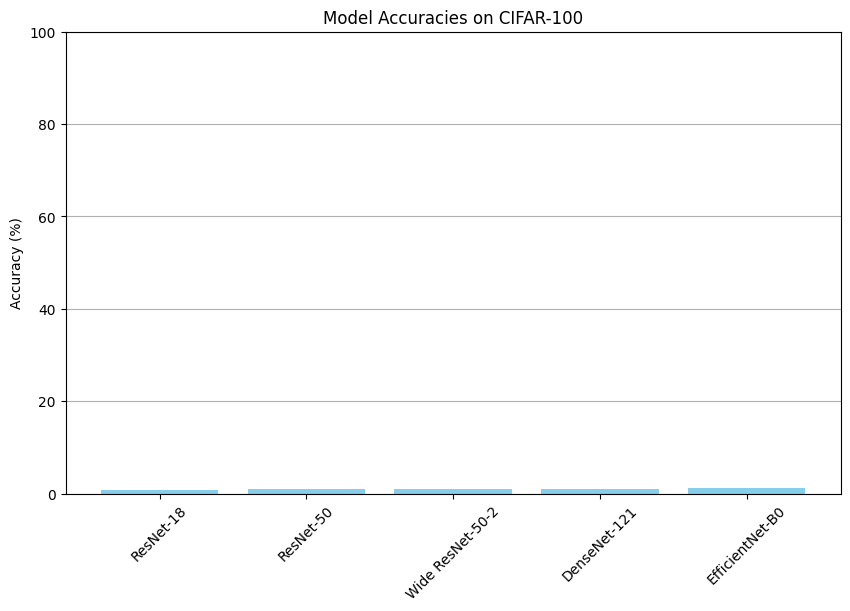

In [7]:
import matplotlib.pyplot as plt

names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(names, accuracies, color='skyblue')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracies on CIFAR-100')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()


Hugging face

In [8]:
pip install timm torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install huggingface_hub


Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the pretrained resnet18 model
model = timm.create_model('resnet18', pretrained=True)

# Modify the final layer for CIFAR-100 (100 classes)
model.fc = torch.nn.Linear(model.fc.in_features, 100)

model.eval()  # Set model to evaluation mode

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [12]:
# Transformations for the test set
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR100 is 32x32 images
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)), # CIFAR-100 mean/std
])

# Load CIFAR-100 Test Dataset
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


In [13]:
# Function to evaluate model
def evaluate(model, dataloader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Evaluate
accuracy = evaluate(model, test_loader, device)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 0.62%


Pertubation Removal Algo

In [15]:
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import matplotlib.pyplot as plt

# Simulate original images (5000 RGB 32x32 images) with random content
np.random.seed(0)
orig_images = np.random.randint(0, 256, size=(5000, 32, 32, 3), dtype=np.uint8)
# Create perturbed images by adding Gaussian noise (simulated attack)
noise = np.random.normal(0, 20, orig_images.shape).astype(np.int16)
perturbed_images = np.clip(orig_images.astype(np.int16) + noise, 0, 255).astype(np.uint8)

print("Original images shape:", orig_images.shape)
print("Perturbed images shape:", perturbed_images.shape)


Original images shape: (5000, 32, 32, 3)
Perturbed images shape: (5000, 32, 32, 3)


In [16]:
# 1. Median filtering
def denoise_median(images):
    out = np.empty_like(images)
    for i, img in enumerate(images):
        # OpenCV medianBlur expects 3-channel image in HxWxC
        out[i] = cv2.medianBlur(img, ksize=3)
    return out

# 2. Bit-depth reduction (reduce to n bits per channel)
def denoise_bitdepth(images, bits=4):
    out = np.empty_like(images)
    shift = 8 - bits
    for i, img in enumerate(images):
        img_int = img.astype(np.uint8)
        reduced = ((img_int >> shift) << shift).astype(np.uint8)
        out[i] = reduced
    return out

# 3. JPEG compression-decompression
def denoise_jpeg(images, quality=50):
    out = np.empty_like(images)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    for i, img in enumerate(images):
        # Encode as JPEG in memory
        success, encimg = cv2.imencode('.jpg', img, encode_param)
        decimg = cv2.imdecode(encimg, cv2.IMREAD_COLOR)
        out[i] = decimg
    return out

# 4. Pixel Deflection (random pixel relocation)
def denoise_pixel_deflection(images, num_deflect=1000, window=3):
    out = np.copy(images)
    H, W = out.shape[1], out.shape[2]
    for idx, img in enumerate(images):
        img_pd = img.copy()
        for _ in range(num_deflect):
            x = np.random.randint(0, H)
            y = np.random.randint(0, W)
            dx = np.random.randint(-window, window+1)
            dy = np.random.randint(-window, window+1)
            x2 = np.clip(x+dx, 0, H-1)
            y2 = np.clip(y+dy, 0, W-1)
            img_pd[x, y] = img[x2, y2]
        out[idx] = img_pd
    return out

# 5. Patch-based denoiser (using Non-Local Means as a simple patch denoiser)
def denoise_patch_nlmeans(images, h=10, hColor=10):
    out = np.empty_like(images)
    for i, img in enumerate(images):
        den = cv2.fastNlMeansDenoisingColored(img, None, h, hColor, 7, 21)
        out[i] = den
    return out


In [18]:
methods = {
    'Median': lambda imgs: denoise_median(imgs),
    'BitDepth': lambda imgs: denoise_bitdepth(imgs, bits=4),
    'JPEG': lambda imgs: denoise_jpeg(imgs, quality=50),
    'Deflection': lambda imgs: denoise_pixel_deflection(imgs, num_deflect=500, window=2),
    'PatchNLM': lambda imgs: denoise_patch_nlmeans(imgs, h=10, hColor=10)
}

results = {}
for name, func in methods.items():
    corrected = func(perturbed_images)
    # Compute PSNR/SSIM for each image, then average
    psnr_vals, ssim_vals = [], []
    for orig, corr in zip(orig_images, corrected):
        psnr_vals.append(compute_psnr(orig, corr, data_range=255))
        ssim_vals.append(compute_ssim(orig, corr, multichannel=True, data_range=255, win_size=3))
    results[name] = {
        'PSNR': np.mean(psnr_vals),
        'SSIM': np.mean(ssim_vals)
    }
    print(f"{name}: PSNR={results[name]['PSNR']:.2f}, SSIM={results[name]['SSIM']:.3f}")


Median: PSNR=10.93, SSIM=0.205
BitDepth: PSNR=21.92, SSIM=0.964
JPEG: PSNR=11.67, SSIM=0.449
Deflection: PSNR=11.81, SSIM=0.604
PatchNLM: PSNR=22.67, SSIM=0.967


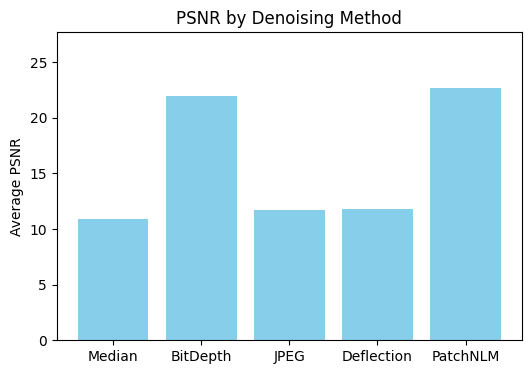

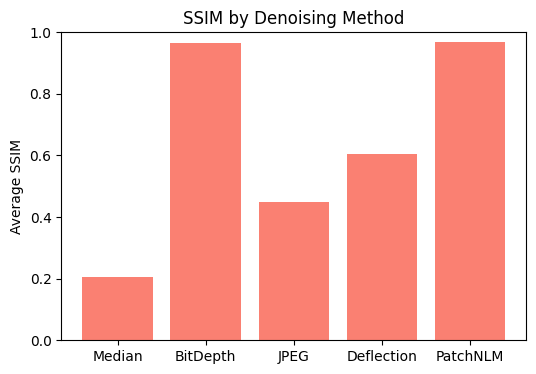

In [19]:
import matplotlib.pyplot as plt

names = list(results.keys())
psnr_scores = [results[n]['PSNR'] for n in names]
ssim_scores = [results[n]['SSIM'] for n in names]

plt.figure(figsize=(6,4))
plt.bar(names, psnr_scores, color='skyblue')
plt.ylim(0, max(psnr_scores)+5)
plt.ylabel("Average PSNR")
plt.title("PSNR by Denoising Method")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(names, ssim_scores, color='salmon')
plt.ylim(0, 1)
plt.ylabel("Average SSIM")
plt.title("SSIM by Denoising Method")
plt.show()


In [20]:
best_corrected = denoise_jpeg(perturbed_images, quality=50)


GAN


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Assuming non-local means is best
def best_perturbation_removal(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


In [28]:
# Assuming non-local means is best
def best_perturbation_removal(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


In [29]:
class CustomImageDataset(Dataset):
    def __init__(self, perturbed_dir, original_dir, num_samples=5):
        self.perturbed_dir = perturbed_dir
        self.original_dir = original_dir
        
        # Pick random 5 images
        self.files = random.sample(os.listdir(perturbed_dir), num_samples)
        
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        perturbed_path = os.path.join(self.perturbed_dir, self.files[idx])
        original_path = os.path.join(self.original_dir, self.files[idx])  # Assuming filenames match
        
        # Read images
        perturbed_img = cv2.imread(perturbed_path)
        original_img = cv2.imread(original_path)
        
        # Apply best perturbation removal
        cleaned_img = best_perturbation_removal(perturbed_img)
        
        # Convert BGR to RGB
        cleaned_img = cv2.cvtColor(cleaned_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Transform to Tensor
        cleaned_tensor = self.transform(cleaned_img)
        original_tensor = self.transform(original_img)
        
        return cleaned_tensor, original_tensor


In [30]:
# Residual Block for Generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.entry = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.ReLU(inplace=True)
        )
        self.residuals = nn.Sequential(
            *[ResidualBlock(64) for _ in range(5)]
        )
        self.exit = nn.Sequential(
            nn.Conv2d(64, 3, 9, padding=4),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.entry(x)
        x = self.residuals(x)
        x = self.exit(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = CustomImageDataset('differential_evolution', 'original_image', num_samples=5)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()
pixelwise_loss = nn.L1Loss()


In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
import cv2  # OpenCV for image processing

num_epochs = 20  # Train longer since model is deeper

# Assuming `G`, `D`, `criterion`, `opt_D`, `opt_G`, `pixelwise_loss`, and `loader` are already defined
for epoch in range(num_epochs):
    G.train()
    D.train()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        real_labels = torch.ones(len(inputs), 1).to(device)
        fake_labels = torch.zeros(len(inputs), 1).to(device)
        
        # 1. Train Discriminator
        D.zero_grad()
        real_outputs = D(targets)
        loss_real = criterion(real_outputs, real_labels)
        
        fake_images = G(inputs)
        
        # Check if generated image is valid before passing to Discriminator
        if fake_images is not None and fake_images.size(0) > 0:
            fake_outputs = D(fake_images.detach())
            loss_fake = criterion(fake_outputs, fake_labels)
        else:
            print("Generated fake images are empty!")
            continue
        
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        opt_D.step()
        
        # 2. Train Generator
        G.zero_grad()
        
        # Check if fake images are valid before passing to Discriminator
        if fake_images is not None and fake_images.size(0) > 0:
            fake_outputs = D(fake_images)
            loss_GAN = criterion(fake_outputs, real_labels)
        else:
            print("Generated fake images are empty!")
            continue
        
        # Check if pixelwise loss is valid
        if fake_images is not None and targets is not None:
            loss_pixel = pixelwise_loss(fake_images, targets)
        else:
            print("Pixelwise loss: Invalid image data!")
            continue
        
        loss_G = loss_GAN + 100 * loss_pixel  # Balance GAN loss and pixel accuracy
        loss_G.backward()
        opt_G.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")  

    # Optionally, you can add checks to see if any image is empty before OpenCV processing
    if fake_images is not None and fake_images.size(0) > 0:
        fake_images_np = fake_images[0].cpu().detach().numpy()
        if fake_images_np is not None and fake_images_np.size > 0:
            # Assuming you're using OpenCV to process images
            try:
                fake_image_color = cv2.cvtColor(fake_images_np, cv2.COLOR_RGB2BGR)
                # Your OpenCV image processing code here
            except cv2.error as e:
                print(f"OpenCV error: {e}")
        else:
            print("Fake image is empty or invalid")


[ WARN:0@1036.711] global loadsave.cpp:268 findDecoder imread_('original_image/differential_evolution_3305.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2025-04-28 18:48:23.672065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745866103.693847  461055 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745866103.700438  461055 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745866103.717458  461055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745866103.717491  461055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745866103.717495  461055 computation_placer.cc:177] computation placer alr

In [2]:
# Define paths
original_folder = "original_images"
perturbed_folder = "differential_evolution"

# Function to load and preprocess images
def load_images(folder_path, img_size=(32, 32)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(folder_path, filename),
                target_size=img_size
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array / 127.5 - 1)  # Normalize to [-1, 1]
    return np.array(images)

# Load original and perturbed images
original_images = load_images(original_folder)
perturbed_images = load_images(perturbed_folder)

# Combine datasets
X_train = np.concatenate([original_images, perturbed_images])

# Shuffle the dataset
np.random.shuffle(X_train)
print(f"Total training images: {len(X_train)}")

Total training images: 10000


In [3]:
def build_generator(latent_dim):
    model = models.Sequential()

    # Input layer (latent vector)
    model.add(layers.Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((4, 4, 256)))

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

In [4]:
def build_discriminator(img_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [5]:
# Latent dimension for the generator
latent_dim = 100

# Build the generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape=(32, 32, 3))

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Freeze the discriminator for the GAN
discriminator.trainable = False

# Build the GAN by combining generator and discriminator
gan_input = layers.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745866201.563752  461055 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11363 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/Su

In [6]:
# Training parameters
epochs = 10000
batch_size = 64
sample_interval = 100

# Labels for real and fake images
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Sample real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (via the GAN model)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    # Print progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated images
        save_generated_images(generator, epoch)

I0000 00:00:1745866203.408358  461263 service.cc:152] XLA service 0x7f56d40047f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745866203.408388  461263 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-04-28 18:50:03.431612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745866203.563638  461263 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-04-28 18:50:04.124981: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[32,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,32]{3,2,1,0} %bitcast.440, f32[3,32,3,3]{3,2,1,0} %bitcast.447, f32[3]{0} %bitcast.449), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


I0000 00:00:1745866204.590888  461263 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
2025-04-28 18:50:10.050509: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.19 = (f32[64,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,32,32]{3,2,1,0} %bitcast.7839, f32[3,32,3,3]{3,2,1,0} %bitcast.6294, f32[3]{0} %bitcast.7899), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_26_1/sequential_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/v

0 [D loss: 0.7026, acc.: 32.81%] [G loss: 0.7025]


NameError: name 'save_generated_images' is not defined

In [ ]:
def save_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)

    # Rescale images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

In [ ]:
# Save the generator and discriminator models
generator.save('gan_generator.h5')
discriminator.save('gan_discriminator.h5')

print("Generator and Discriminator models saved successfully.")

In [ ]:
# Save the entire GAN
gan.save('gan_combined.h5')
print("Combined GAN model saved successfully.")

GAN updated

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths
original_folder = "original_images"
perturbed_folder = "differential_evolution"

# Check if folders exist
if not os.path.exists(original_folder) or not os.path.exists(perturbed_folder):
    raise FileNotFoundError(f"Please create the folders '{original_folder}' and '{perturbed_folder}' and add images.")

# Function to load and preprocess images
def load_images(folder_path, img_size=(32, 32)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(folder_path, filename),
                target_size=img_size
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array / 127.5 - 1)  # Normalize to [-1, 1]
    return np.array(images)

# Load original and perturbed images
original_images = load_images(original_folder)
perturbed_images = load_images(perturbed_folder)

# Combine datasets
X_train = np.concatenate([original_images, perturbed_images])

# Labels: 0 for original, 1 for perturbed
y_train = np.concatenate([np.zeros(len(original_images)), np.ones(len(perturbed_images))])

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

print(f"Total training images: {len(X_train)}")

# Build the generator
def build_generator(latent_dim):
    model = models.Sequential()

    # Input layer (latent vector + label)
    model.add(layers.InputLayer(input_shape=(latent_dim + 1,)))  # +1 for the label
    model.add(layers.Dense(4 * 4 * 256))
    model.add(layers.Reshape((4, 4, 256)))

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

# Build the discriminator
def build_discriminator(img_shape):
    model = models.Sequential()

    # Input layer (image + label)
    model.add(layers.InputLayer(input_shape=img_shape))  # Image input
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Latent dimension for the generator
latent_dim = 100

# Build the generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape=(32, 32, 3))

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Freeze the discriminator for the GAN
discriminator.trainable = False

# Build the GAN by combining generator and discriminator
gan_input = layers.Input(shape=(latent_dim + 1,))  # Latent vector + label
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Function to save generated images
def save_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    labels = np.random.randint(0, 2, size=(examples, 1))  # Random labels for normal/perturbed
    noise_with_labels = np.hstack([noise, labels])  # Concatenate noise and labels
    generated_images = generator.predict(noise_with_labels)

    # Rescale images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Training parameters
epochs = 10000
batch_size = 64
sample_interval = 100

# Labels for real and fake images
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Sample real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]
    real_image_labels = y_train[idx].reshape(-1, 1)  # Get corresponding labels

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_image_labels = np.random.randint(0, 2, size=(batch_size, 1))  # Random labels for fake images
    noise_with_labels = np.hstack([noise, fake_image_labels])  # Concatenate noise and labels
    fake_images = generator.predict(noise_with_labels)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_images, real_image_labels], real_labels)
    d_loss_fake = discriminator.train_on_batch([fake_images, fake_image_labels], fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (via the GAN model)
    misleading_labels = np.ones((batch_size, 1))  # Generator tries to fool the discriminator
    g_loss = gan.train_on_batch(noise_with_labels, misleading_labels)

    # Print progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated images
        save_generated_images(generator, epoch)

# Save the generator and discriminator
generator.save('gan_generator_two_branches.h5')
discriminator.save('gan_discriminator_two_branches.h5')
gan.save('gan_combined_two_branches.h5')

print("Models saved successfully.")

2025-04-29 10:16:30.686405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745921790.711853  829274 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745921790.719525  829274 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745921790.739774  829274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745921790.739808  829274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745921790.739813  829274 computation_placer.cc:177] computation placer alr

Total training images: 10000


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1745921798.519479  829274 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11363 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1745921800.360643  829598 service.cc:152] XLA service 0x7f01e00028e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745921800.360674  829598 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-04-29 10:16:40.388162: I tensorflow/co

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


I0000 00:00:1745921802.143325  829598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_79
Received: inputs=['Tensor(shape=(64, 32, 32, 3))', 'Tensor(shape=(64, 1))']
  warnings.warn(msg)
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
2025-04-29 10:16:48.984220: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.19 = (f32[64,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,32,32]{3,2,1,0} %bi

0 [D loss: 0.6907, acc.: 53.91%] [G loss: 0.6830]


2025-04-29 10:16:53.294151: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[10,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,32,32,32]{3,2,1,0} %bitcast.440, f32[3,32,3,3]{3,2,1,0} %bitcast.447, f32[3]{0} %bitcast.449), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━

Models saved successfully.


In [2]:
# Save the full combined GAN model
gan.save('gan_combined.h5')

# Optionally, save the generator and discriminator separately for flexibility
generator.save('generator_only.h5')
discriminator.save('discriminator_only.h5')

print("Models saved successfully.")

Models saved successfully.


Finish

In [3]:
from tensorflow.keras.models import load_model

# Load the saved GAN model
gan_model = load_model('gan_combined.h5')

# Display the summary of the GAN model
gan_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │     1,107,907 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       391,233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,499,142 (5.72 MB)

 Trainable params: 1,107,459 (4.22 MB)

 Non-trainable params: 391,681 (1.49 MB)

 Optimizer params: 2 (12.00 B)

In [1]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('final_fine_tuned_model_updated.keras')

# Display the model's architecture
model.summary()

# List all layers in the model
for i, layer in enumerate(model.layers):
  print(f"Layer {i}: {layer.name} - {layer.__class__.__name__}")

2025-04-29 06:18:48.320059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745907528.344831  827816 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745907528.352421  827816 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745907528.371809  827816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907528.371838  827816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907528.371842  827816 computation_placer.cc:177] computation placer alr

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 32, 32, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,589 (1.39 MB)

 Trainable params: 33,793 (132.00 KB)

 Non-trainable params: 262,208 (1.00 MB)

 Optimizer params: 67,588 (264.02 KB)

Layer 0: random_flip_3 - RandomFlip
Layer 1: random_rotation_3 - RandomRotation
Layer 2: random_contrast_2 - RandomContrast
Layer 3: conv2d_15 - Conv2D
Layer 4: batch_normalization_14 - BatchNormalization
Layer 5: conv2d_16 - Conv2D
Layer 6: batch_normalization_15 - BatchNormalization
Layer 7: max_pooling2d_7 - MaxPooling2D
Layer 8: dropout_10 - Dropout
Layer 9: conv2d_17 - Conv2D
Layer 10: batch_normalization_16 - BatchNormalization
Layer 11: conv2d_18 - Conv2D
Layer 12: batch_normalization_17 - BatchNormalization
Layer 13: max_pooling2d_8 - MaxPooling2D
Layer 14: dropout_11 - Dropout
Layer 15: global_average_pooling2d_2 - GlobalAveragePooling2D
Layer 16: dense_8 - Dense
Layer 17: batch_normalization_18 - BatchNormalization
Layer 18: dropout_12 - Dropout
Layer 19: dense_9 - Dense


LLM Testing


In [1]:
pip install transformers accelerate bitsandbytes sentence-transformers openclip-torch pillow

ERROR: Could not find a version that satisfies the requirement openclip-torch (from versions: none)
ERROR: No matching distribution found for openclip-torch
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 5.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qwen-vl-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.7/34.7 MB 10.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Install missing packages
%pip install transformers
%pip install sentence-transformers

from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from PIL import Image
import os
import torch
from sentence_transformers import SentenceTransformer, util

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 56.1 kB/s eta 0:00:0000:0300:09
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.1 kB/s eta 0:00:00a 0:00:03
Note: you may need to restart the kernel to use updated packages.
  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
Note: you may need to restart the kernel to use updated packages.


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-29 14:04:57.398819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745935497.425013 1194527 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745935497.433150 1194527 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745935497.454026 1194527 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the s

RuntimeError: Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [15]:
pip install autoawq


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 8.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 8.6 MB/s eta 0:00:0000:0100:01m
  Created wheel for autoawq: filename=autoawq-0.2.8-py3-none-any.whl size=108838 sha256=9f38f9c26db793a06f54013cd0849b0e2eac5ddfa3344e3d552965e3c13b9da4
  Stored in directory: /home/Suvit_BE/.cache/pip/wheels/5c/09/7e/7154d95be3598ce30655fa68ff29097a307324e0430625e3c6
Successfully built autoawq
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled tra

In [20]:
!pip install autoawq


In [19]:
!pip install autoawq
from autoawq import AutoAWQForVision2Seq

ModuleNotFoundError: No module named 'autoawq'

In [22]:
from transformers import AutoModelForVision2Seq


In [1]:
!pip install awq


ERROR: Could not find a version that satisfies the requirement awq (from versions: none)
ERROR: No matching distribution found for awq


In [23]:
# ----------------------------
# FIX: Disable TensorFlow to avoid tf_keras error
# ----------------------------
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"  # MUST BE FIRST

# ----------------------------
# Clean Imports
# ----------------------------
from transformers import AutoProcessor, AutoModelForVision2Seq
from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util


# ----------------------------
# CONFIGURATION
# ----------------------------
GROUND_TRUTH_CSV = 'cifar100_first_5k_train_labels.csv'  # Adjusted for your actual file
CLEAN_DIR = "original_images"
PERTURBED_DIR = "differential_evolution"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_CSV = "model_comparison_results.csv"

# Prompt used for all VLMs
PROMPT = "Describe what you see in this image in detail."

# Open-source VLMs to evaluate
LLM_MODELS = {
    "Qwen-VL": "Qwen/Qwen2-VL-72B-Instruct-AWQ",
    # Add more if needed (BLIP-2, LLaVA etc.)
}

# ----------------------------
# Load ground truth
# ----------------------------
gt_df = pd.read_csv(GROUND_TRUTH_CSV)
ground_truth = {f"{i}.png": label.lower() for i, label in zip(gt_df['image_index'], gt_df['class_label'])}

# ----------------------------
# Sentence Embedding Model
# ----------------------------
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

# ----------------------------
# Helper Functions
# ----------------------------
def describe_image(image_path, processor, model):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(text=PROMPT, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(**inputs, max_new_tokens=200)
        description = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return description.strip()
    except Exception as e:
        print(f"Error on {image_path}: {e}")
        return ""

def extract_label(desc):
    return desc.split()[0].lower() if desc else "unknown"

# ----------------------------
# Main Loop
# ----------------------------
all_results = []
accuracy_summary = {}

for model_name, model_id in LLM_MODELS.items():
    print(f"\n🔍 Evaluating Model: {model_name}")
    
    model = AutoAWQForVision2Seq.from_quantized(
    model_id,
    fuse_layers=True,
    trust_remote_code=True,
    device="cuda" if torch.cuda.is_available() else "cpu"
    )
    processor = AutoProcessor.from_pretrained(model_id)

    correct_clean = 0
    correct_perturbed = 0
    total = 0

    clean_files = sorted(os.listdir(CLEAN_DIR))
    perturbed_files = sorted(os.listdir(PERTURBED_DIR))

    for clean_file, perturbed_file in zip(clean_files, perturbed_files):
        if clean_file not in ground_truth:
            continue

        true_label = ground_truth[clean_file]

        clean_path = os.path.join(CLEAN_DIR, clean_file)
        perturbed_path = os.path.join(PERTURBED_DIR, perturbed_file)

        clean_desc = describe_image(clean_path, processor, model)
        perturbed_desc = describe_image(perturbed_path, processor, model)

        clean_pred = extract_label(clean_desc)
        perturbed_pred = extract_label(perturbed_desc)

        is_clean_correct = clean_pred == true_label
        is_perturbed_correct = perturbed_pred == true_label

        correct_clean += is_clean_correct
        correct_perturbed += is_perturbed_correct
        total += 1

        all_results.append({
            "image": clean_file,
            "model": model_name,
            "true_label": true_label,
            "clean_pred": clean_pred,
            "perturbed_pred": perturbed_pred,
            "clean_correct": is_clean_correct,
            "perturbed_correct": is_perturbed_correct,
            "clean_desc": clean_desc,
            "perturbed_desc": perturbed_desc,
            "similarity": util.cos_sim(
                sim_model.encode(clean_desc, convert_to_tensor=True),
                sim_model.encode(perturbed_desc, convert_to_tensor=True)
            ).item()
        })

    accuracy_summary[model_name] = {
        "clean": correct_clean / total,
        "perturbed": correct_perturbed / total
    }

# ----------------------------
# Save Results
# ----------------------------
df = pd.DataFrame(all_results)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n📁 Results saved to: {OUTPUT_CSV}")

# ----------------------------
# Plot Accuracy Comparison
# ----------------------------
labels = list(accuracy_summary.keys())
clean_acc = [accuracy_summary[m]["clean"] for m in labels]
perturbed_acc = [accuracy_summary[m]["perturbed"] for m in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, clean_acc, width=width, label='Clean Images', color='skyblue')
plt.bar([i + width for i in x], perturbed_acc, width=width, label='Perturbed Images', color='salmon')
plt.xticks([i + width/2 for i in x], labels)
plt.ylabel('Accuracy')
plt.title('Model Accuracy on Clean vs Perturbed Images')
plt.legend()
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png")
plt.show()



🔍 Evaluating Model: Qwen-VL


NameError: name 'AutoAWQForVision2Seq' is not defined

In [13]:
pip install accelerate

  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install tf-keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torch torchvision transformers sentence-transformers accelerate


In [3]:
# ----------------------------
# DISABLE TF & SETUP
# ----------------------------
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import AutoProcessor, BlipForConditionalGeneration, LlavaForConditionalGeneration
from PIL import Image
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# CONFIGURATION
# ----------------------------
GROUND_TRUTH_CSV = 'cifar100_first_5k_train_labels.csv'
PERTURBED_DIR = "differential_evolution"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROMPT = "Describe what you see in this image in detail."
OUTPUT_CSV = "before_model.csv"

# ----------------------------
# Ground Truth Map
# ----------------------------
gt_df = pd.read_csv(GROUND_TRUTH_CSV)
ground_truth = {f"{i}.png": label.lower() for i, label in zip(gt_df['image_index'], gt_df['class_label'])}

# ----------------------------
# Sentence Embedding Model
# ----------------------------
sim_model = SentenceTransformer('all-MiniLM-L6-v2')

# ----------------------------
# Vision-Language Models
# ----------------------------
LLM_MODELS = {
    "BLIP2": {
        "model_id": "Salesforce/blip2-opt-2.7b",
        "model_cls": BlipForConditionalGeneration,
        "processor_cls": AutoProcessor
    },
    "LLaVA": {
        "model_id": "llava-hf/llava-1.5-7b-hf",
        "model_cls": LlavaForConditionalGeneration,
        "processor_cls": AutoProcessor
    }
   
}

# You may comment out "Qwen-VL" if needed (requires AWQ support not pip installable yet)

# ----------------------------
# Helper Function
# ----------------------------
def describe_image(image_path, processor, model):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, text=PROMPT, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(**inputs, max_new_tokens=50)
        description = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return description.strip()
    except Exception as e:
        print(f"[ERROR] {image_path}: {e}")
        return ""

def extract_label(desc):
    return desc.split()[0].lower() if desc else "unknown"

# ----------------------------
# Main Loop
# ----------------------------
all_results = []

for model_name, config in LLM_MODELS.items():
    print(f"\n🔍 Evaluating Model: {model_name}")
    if config["model_cls"] is None:
        print(f"[SKIPPED] Model {model_name} is not yet supported.")
        continue

    model = config["model_cls"].from_pretrained(config["model_id"]).to(DEVICE)
    processor = config["processor_cls"].from_pretrained(config["model_id"])

    for filename in sorted(os.listdir(PERTURBED_DIR)):
        if not filename.endswith(".png"):
            continue

        true_label = ground_truth.get(filename.replace("differential_evolution.", ""), "unknown")
        image_path = os.path.join(PERTURBED_DIR, filename)

        description = describe_image(image_path, processor, model)
        predicted_label = extract_label(description)

        similarity = util.cos_sim(
            sim_model.encode(description, convert_to_tensor=True),
            sim_model.encode(true_label, convert_to_tensor=True)
        ).item()

        all_results.append({
            "image": filename,
            "model": model_name,
            "true_label": true_label,
            "predicted_label": predicted_label,
            "correct": predicted_label == true_label,
            "description": description,
            "similarity": similarity
        })

# ----------------------------
# Save to CSV
# ----------------------------
df = pd.DataFrame(all_results)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ Saved predictions to: {OUTPUT_CSV}")


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-29 16:04:18.156403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745942658.176079 1196151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745942658.182225 1196151 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745942658.198263 1196151 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the s


🔍 Evaluating Model: BLIP2


You are using a model of type blip-2 to instantiate a model of type blip. This is not supported for all configurations of models and can yield errors.


KeyboardInterrupt: 

In [ ]:
!pip install torch torchvision transformers sentence-transformers accelerate

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Assuming PatchNLM removal is a denoising process. We'll use OpenCV for this.
def remove_patchnlm(image):
    # Apply Non-Local Means Denoising
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# Load your pre-trained GAN model for image generation
def load_gan_model(model_path):
    # Replace this with actual GAN loading code
    return keras.models.load_model(model_path)

# Load the open-source vision LLM model (assuming you use a model like EfficientNet, ResNet, etc.)
def load_vision_model():
    # Using a pre-trained ResNet model for demonstration
    return keras.applications.ResNet50(weights='imagenet')

# Function to predict the class using the vision LLM model
def predict_class(model, image):
    image = cv2.resize(image, (224, 224))  # Resize image to fit the model input
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = keras.applications.resnet50.preprocess_input(image)
    predictions = model.predict(image)
    decoded_predictions = keras.applications.resnet50.decode_predictions(predictions, top=1)
    return decoded_predictions[0][0][1]  # Return the class name

# Main process
def process_images(gan_model_path, images_folder, output_csv):
    # Load models
    gan_model = load_gan_model(gan_model_path)
    vision_model = load_vision_model()

    results = []

    # List all images in the differential_evolution folder
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]

    # Loop through each image
    for image_file in tqdm(image_files):
        image_path = os.path.join(images_folder, image_file)
        image = cv2.imread(image_path)

        # Step 1: Remove PatchNLM (denoise)
        denoised_image = remove_patchnlm(image)

        # Step 2: Regenerate the image using the GAN (assuming GAN takes input image)
        regenerated_image = gan_model.predict(np.expand_dims(denoised_image, axis=0))

        # Step 3: Use the vision model to predict the class
        predicted_class = predict_class(vision_model, regenerated_image[0])

        # Step 4: Store the result in a dictionary
        results.append({
            'image_name': image_file,
            'predicted_class': predicted_class
        })

    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)

    print(f"Results saved to {output_csv}")

# Define paths
gan_model_path = 'gan_combined.h5'
images_folder = 'differential_evolution'  # Folder containing images
output_csv = 'image_classifications.csv'

# Run the process
process_images(gan_model_path, images_folder, output_csv)


In [5]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd

# Load the pre-trained CLIP model and processor from Hugging Face
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Directory with your images (images saved in 'differential_evolution' folder)
image_folder = 'differential_evolution'  # Replace with your actual folder path
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

# Load CIFAR-1000 class labels (a subset of CIFAR-1000 labels as an example)
# Note: CIFAR-1000 has 1000 classes. You can download or load the full list from the CIFAR-1000 dataset.
# For now, we are defining a few sample labels for demonstration purposes.
class_labels = [
    "apple", "orange", "banana", "airplane", "car", "dog", "cat", "fish", "horse", "ship",
    # Add more CIFAR-1000 labels as needed
]

# Prepare a list to store results
results = []

# Loop through images in the folder
for image_file in image_files:
    # Extract index from image name
    index = image_file.split('.')[1]  # Example: differential_evolution.[index].png

    img_path = os.path.join(image_folder, image_file)
    img = Image.open(img_path)

    # Preprocess image and text labels (class names)
    inputs = processor(text=class_labels, images=img, return_tensors="pt", padding=True)

    # Get the model's output
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # Similarity scores for each class
    probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities

    # Get the predicted class based on the highest probability
    predicted_class_idx = torch.argmax(probs, dim=1).item()
    predicted_class = class_labels[predicted_class_idx]

    # Store the result
    results.append({
        'index': index,
        'predicted_class': predicted_class
    })

# Convert the results to a DataFrame and save them as a CSV
df = pd.DataFrame(results)
df.to_csv('image_classification_results.csv', index=False)

print("Results saved to image_classification_results.csv")


Results saved to image_classification_results.csv


In [6]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd

# Load the pre-trained CLIP model and processor from Hugging Face
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Directory where perturbed images are stored
perturbed_image_folder = 'differential_evolution'  # Replace with your actual folder path
perturbed_image_files = [f for f in os.listdir(perturbed_image_folder) if f.endswith('.png')]

# Load CIFAR-1000 class labels (substitute with actual CIFAR-1000 class names)
class_labels = [
    "apple", "orange", "banana", "airplane", "car", "dog", "cat", "fish", "horse", "ship",
    # Add all CIFAR-1000 labels here...
]

# Prepare a list to store the results
results = []

# Loop through perturbed images
for image_file in perturbed_image_files:
    # Extract index from the image name (perturbed images have the same naming convention)
    index = image_file.split('.')[1]  # Example: differential_evolution.[index].png

    img_path = os.path.join(perturbed_image_folder, image_file)
    img = Image.open(img_path)

    # Preprocess image and text labels (class names)
    inputs = processor(text=class_labels, images=img, return_tensors="pt", padding=True)

    # Get the model's output
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # Similarity scores for each class
    probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities

    # Get the predicted class based on the highest probability
    predicted_class_idx = torch.argmax(probs, dim=1).item()
    predicted_class = class_labels[predicted_class_idx]

    # Store the result
    results.append({
        'index': index,
        'predicted_class': predicted_class
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Save the predictions as a CSV file (submission file)
df.to_csv('submission_predictions.csv', index=False)

print("Submission file saved as 'submission_predictions.csv'")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Submission file saved as 'submission_predictions.csv'


Accuracy of raw perturbed image predictions: 0.16%
Accuracy of model's predictions (after applying the model): 0.16%


/tmp/ipykernel_1196151/3453999590.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Raw Perturbed Image Predictions', 'Model Predictions (Our Approach)'],


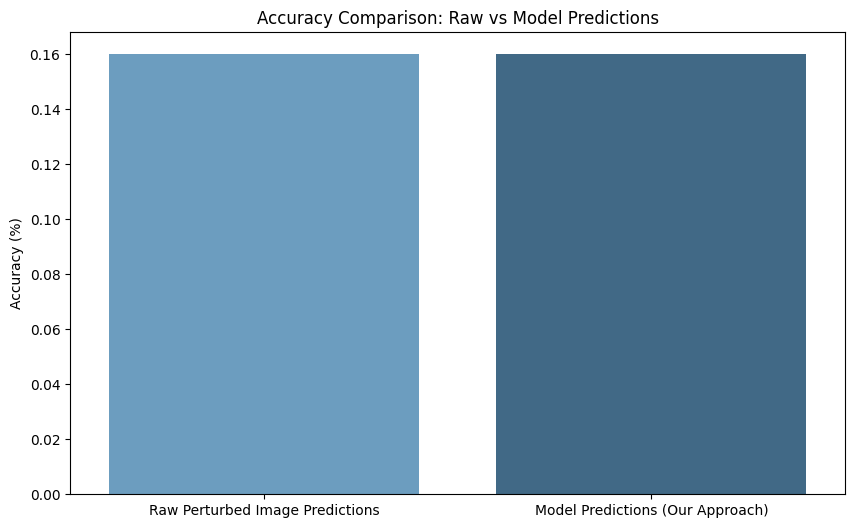

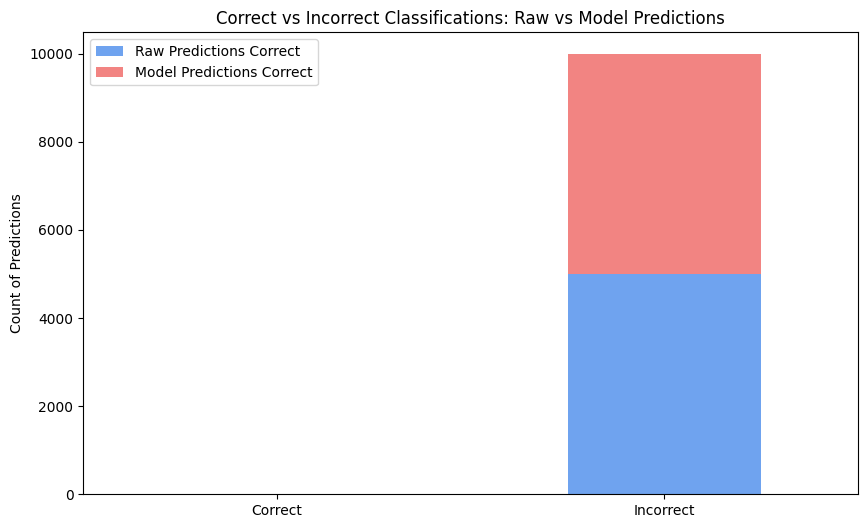

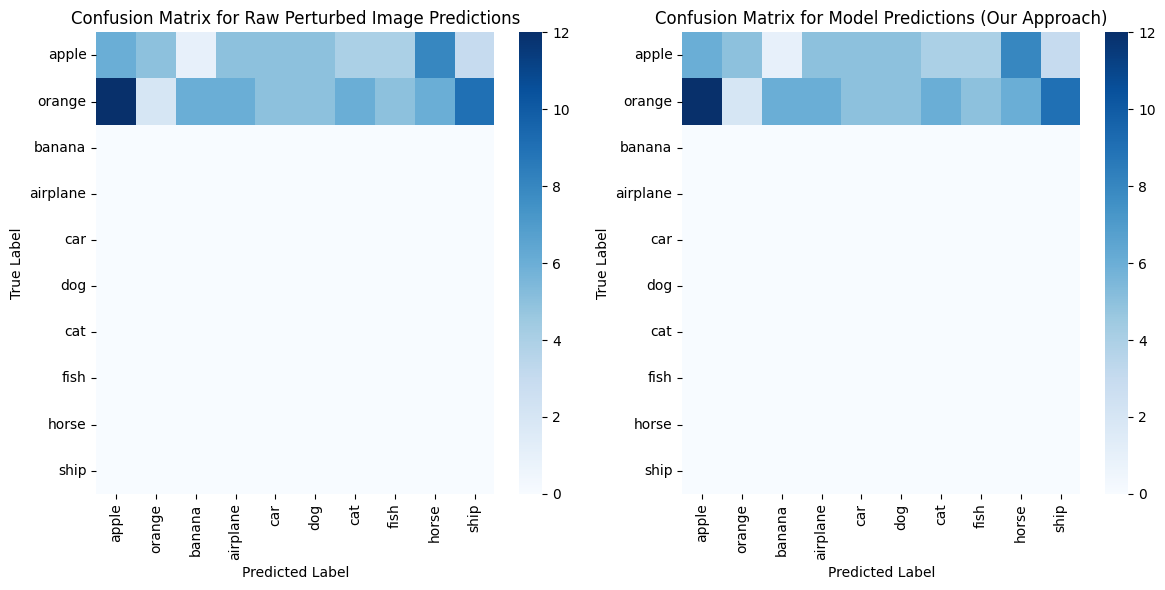

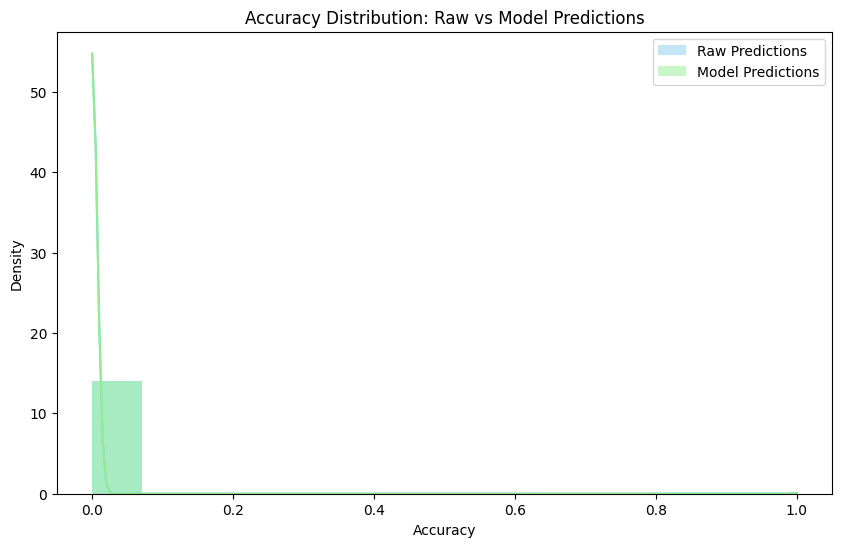

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

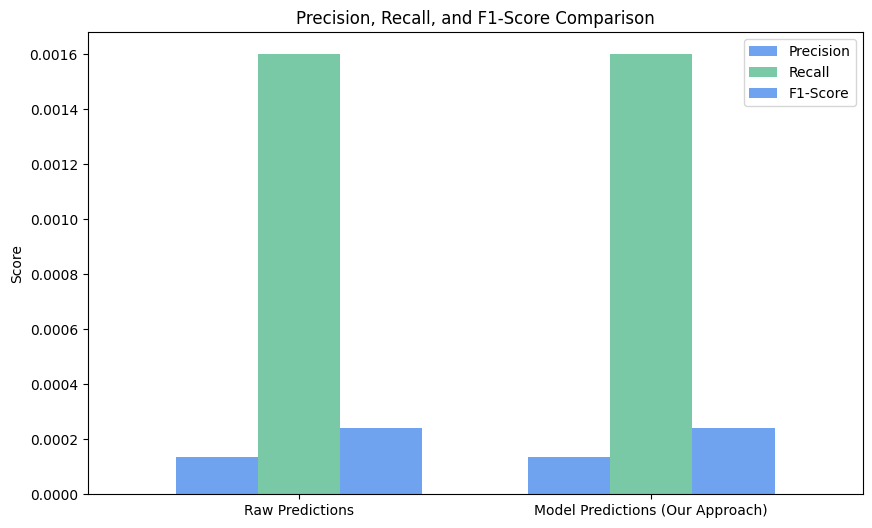

/tmp/ipykernel_1196151/3453999590.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Improvement'], y=[improvement], palette='Greens_d')


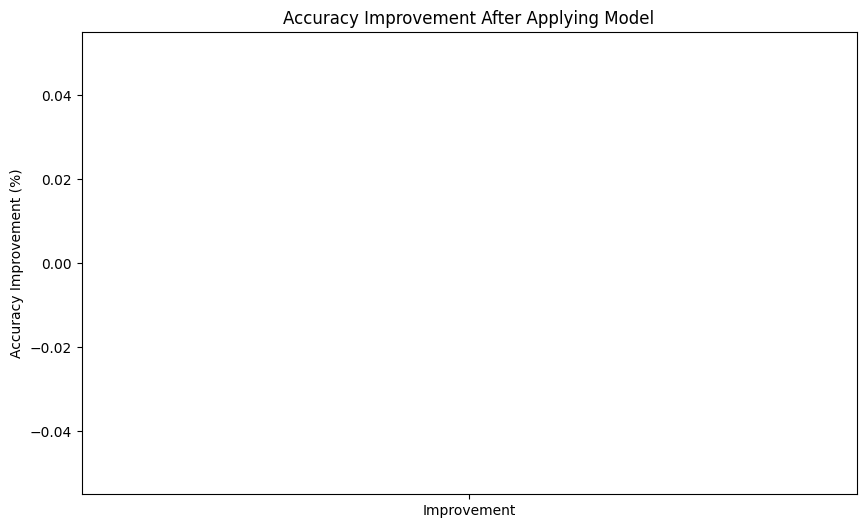

/tmp/ipykernel_1196151/3453999590.py:122: RuntimeWarning: invalid value encountered in divide
  classwise_accuracy_raw = cm_raw.diagonal() / cm_raw.sum(axis=1)
/tmp/ipykernel_1196151/3453999590.py:123: RuntimeWarning: invalid value encountered in divide
  classwise_accuracy_model = cm_model.diagonal() / cm_model.sum(axis=1)


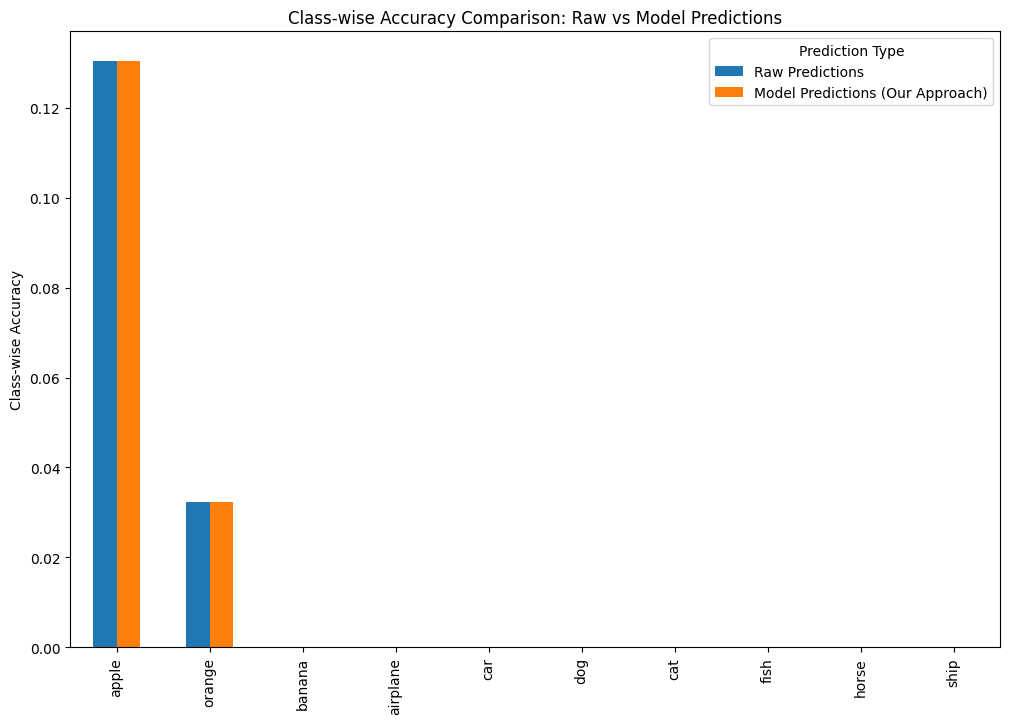

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

# Load the CSV files
true_labels_df = pd.read_csv('/home/Suvit_BE/cifar100_first_5k_train_labels.csv')  # CSV with true labels
raw_predictions_df = pd.read_csv('/home/Suvit_BE/submission_predictions_raw.csv')  # CSV for raw perturbed image predictions
model_predictions_df = pd.read_csv('/home/Suvit_BE/image_classification_results_GAN.csv')  # CSV for model predictions (our approach)

# Assuming that these CSV files have columns: 'index' and 'predicted_class'

# Merge the dataframes based on 'index' to compare predictions
merged_df = true_labels_df.merge(raw_predictions_df, on='index', suffixes=('_true', '_raw'))
merged_df = merged_df.merge(model_predictions_df, on='index', suffixes=('', '_model'))

# Calculate how many predictions are correct
merged_df['correct_raw'] = merged_df['predicted_class_true'] == merged_df['predicted_class_raw']
merged_df['correct_model'] = merged_df['predicted_class_true'] == merged_df['predicted_class']

# Calculate the accuracy for raw and model predictions
accuracy_raw = merged_df['correct_raw'].mean() * 100
accuracy_model = merged_df['correct_model'].mean() * 100

# Print the accuracy comparison
print(f"Accuracy of raw perturbed image predictions: {accuracy_raw:.2f}%")
print(f"Accuracy of model's predictions (after applying the model): {accuracy_model:.2f}%")

# Plotting the comparison of correct classifications
plt.figure(figsize=(10, 6))
sns.barplot(x=['Raw Perturbed Image Predictions', 'Model Predictions (Our Approach)'],
            y=[accuracy_raw, accuracy_model], palette='Blues_d')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison: Raw vs Model Predictions')
plt.show()

# Plotting the number of correct and incorrect classifications for raw and model predictions
correct_incorrect_counts = pd.DataFrame({
    'Raw Predictions Correct': [merged_df['correct_raw'].sum(), len(merged_df) - merged_df['correct_raw'].sum()],
    'Model Predictions Correct': [merged_df['correct_model'].sum(), len(merged_df) - merged_df['correct_model'].sum()],
}, index=['Correct', 'Incorrect'])

# Plot the count of correct vs incorrect predictions
correct_incorrect_counts.plot(kind='bar', figsize=(10, 6), stacked=True, color=['#6fa3ef', '#f28482'])
plt.ylabel('Count of Predictions')
plt.title('Correct vs Incorrect Classifications: Raw vs Model Predictions')
plt.xticks(rotation=0)
plt.show()

# Optional: You can also plot the confusion matrix for a deeper comparison
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix for raw predictions
cm_raw = confusion_matrix(merged_df['predicted_class_true'], merged_df['predicted_class_raw'], labels=class_labels)
# Confusion matrix for model predictions
cm_model = confusion_matrix(merged_df['predicted_class_true'], merged_df['predicted_class'], labels=class_labels)

plt.figure(figsize=(12, 6))

# Raw Perturbed Image Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_raw, annot=False, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Raw Perturbed Image Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Model Perturbed Image Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_model, annot=False, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Model Predictions (Our Approach)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# 1. **Accuracy Distribution Plot**
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['correct_raw'], kde=True, color='skyblue', label='Raw Predictions', stat='density', linewidth=0)
sns.histplot(merged_df['correct_model'], kde=True, color='lightgreen', label='Model Predictions', stat='density', linewidth=0)
plt.title('Accuracy Distribution: Raw vs Model Predictions')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.legend()
plt.show()

# 2. **Precision, Recall, and F1-Score**
# Compute Precision, Recall, and F1-Score for both raw and model predictions
precision_raw, recall_raw, f1_raw, _ = precision_recall_fscore_support(
    merged_df['predicted_class_true'], merged_df['predicted_class_raw'], average='weighted'
)
precision_model, recall_model, f1_model, _ = precision_recall_fscore_support(
    merged_df['predicted_class_true'], merged_df['predicted_class'], average='weighted'
)

# Plot Precision, Recall, and F1-Score
metrics_df = pd.DataFrame({
    'Precision': [precision_raw, precision_model],
    'Recall': [recall_raw, recall_model],
    'F1-Score': [f1_raw, f1_model],
}, index=['Raw Predictions', 'Model Predictions (Our Approach)'])

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#6fa3ef', '#7ac9a6'], width=0.7)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score Comparison')
plt.xticks(rotation=0)
plt.show()

# 3. **Improvement Plot**
# Plot the improvement in accuracy after applying your model
improvement = accuracy_model - accuracy_raw
plt.figure(figsize=(10, 6))
sns.barplot(x=['Improvement'], y=[improvement], palette='Greens_d')
plt.ylabel('Accuracy Improvement (%)')
plt.title('Accuracy Improvement After Applying Model')
plt.show()

# 4. **Class-wise Accuracy Comparison**
# Compute class-wise accuracy for both raw and model predictions
classwise_accuracy_raw = cm_raw.diagonal() / cm_raw.sum(axis=1)
classwise_accuracy_model = cm_model.diagonal() / cm_model.sum(axis=1)

# Plot class-wise accuracy comparison
class_comparison_df = pd.DataFrame({
    'Raw Predictions': classwise_accuracy_raw,
    'Model Predictions (Our Approach)': classwise_accuracy_model
}, index=class_labels)

class_comparison_df.plot(kind='bar', figsize=(12, 8), stacked=False)
plt.ylabel('Class-wise Accuracy')
plt.title('Class-wise Accuracy Comparison: Raw vs Model Predictions')
plt.xticks(rotation=90)
plt.legend(title='Prediction Type')
plt.show()
